In [2]:
import os
import re
import tempfile

import cv2
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
from google.cloud import vision, vision_v1
from google.cloud.vision_v1 import types
from PIL import Image, ImageOps
from tqdm import tqdm

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'rare-chiller-410709-542d31863eb5.json'
client = vision.ImageAnnotatorClient()

def set_image_dpi(image):
    # image = image.convert(mode='L') # grayscale
    length_x, width_y = image.size
    factor = max(1, float(1250.0 / length_x))
    if factor>1:
        size = int(factor * length_x), int(factor * width_y)    
        im_resized = image.resize(size, Image.LANCZOS)
        with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as temp_file:
            temp_filename = temp_file.name
            im_resized.save(temp_filename, dpi=(300, 300))
        return Image.open(temp_filename)
    return image

def process_image(image):
    def combine_channels(image, method='average'):
        if method == 'average':
            return np.mean(image, axis=-1).astype(np.uint8)
        elif method == 'weighted_sum':
            weights = [0.299, 0.587, 0.114]  # RGB to grayscale conversion weights
            return np.dot(image[..., :3], weights).astype(np.uint8)
        else:
            raise ValueError(f"Unsupported method: {method}")
        
    # Blurring image with gaussian blur
    image = cv2.GaussianBlur(image, (7, 7), 0)
    # Combine channels using average
    image = combine_channels(image, method='average')

    return image

def image2text(image):

    def extract_receipt_data(txt):    
        def text_cleaning(text):
            thai_chars = re.findall(re.compile('[\u0E00-\u0E7F]+'), text)  
            if thai_chars != [] : 
                cleaned_text = text.replace(' ', '').replace(',', '').replace('@', '')
                return cleaned_text.lstrip("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!@#$%^&*()_-+=[]{}|;:'\",.<>?/`~") 
            return ''  
        def description_cleaning(products):
            if not products: return []

            excluded_keywords = ['\\*', 'คอยน์', 'คูปอง', 'ชิ้น', 'ทันที', 'บาท', 'ประหยัด', 'ยอด', 'รวม', 'ราคา', 'รีวอร์ด', 'ลด', 'วอลเล็ท',
                                'วอเลท', 'สุทธิ', 'ส่วน', 'ส่วนลด', 'เงิน', 'เงินทอน', 'ถนน', 'มูลค่า', 'รับ', 'สาขา', 'ที่', 'อยู่'
                                'ภาษี', 'สินค้า', 'สะสม', 'กก.ละ', 'TAX']
            return [item for item in products if not re.search('|'.join(excluded_keywords), item[1]) and len(item[1]) > 3]

        def extract_product1(txt):    
            pattern = re.compile(r'(.+?)\n(\d{1,3}) \S{1}? (\d+\.+\d*) (\d+\.+\d+)')
            match = [[match[1], text_cleaning(match[0].replace(' ', '')), match[3]] for match in pattern.findall(txt)]
            
            return description_cleaning(match)

        def extract_product2(txt):
            pattern = re.compile(r'(?:\b(\d{1,3}[A-Z]?)\b )?(.+?) (\d+\.\d+)(?: (\d+\.\d+))?')
            match = [match.groups() for line in txt.splitlines() for match in [pattern.match(line)] if match]
            match =  [[item[0], text_cleaning(item[1]), item[3] if item[3] != None else item[2]] for item in match]
            
            return description_cleaning(match)
        
        def extract_merchant_name(txt):
            keywords = ['CP', 'Eleven', 'Tops', 'BCM', 'BigC', 'บริษัท', 'Lotus']
            return next((line for line in txt.split('\n') if re.search('|'.join(keywords), line)), None)
        
        def extract_merchant_phone(txt):
            pattern =re.compile(r'\(?\b0\d{1,3}\)?[-.\s]?\d{3,4}[-.\s]?\d{4}\b')
            match = pattern.search(txt)
            return match.group() if match else None

        def extract_pos_number(txt):
            pattern = re.compile(r'([a-zA-Z0-9]{15})')
            match = [match.group() for line in txt.splitlines() for match in [pattern.search(line)] if match and  re.search('|'.join(['RID', 'POS']), line)]
            return match[-1] if match else None  
        
        def extract_datetime(txt):
            pattern = re.compile(r'(\d{2}[-/._\.]\d{2}[-/._\.]\d{2,})\s+(\d{2}:\d{2})?') #([0-2]?[0-9][:]*[0-5][0-9])')
            match = pattern.search(txt)
            return match.group() if match else None
        
        def extract_purchase_amount(txt):
            pattern = re.compile(r'(\d+\.+\d+)')
            match = [match.group() for line in txt.splitlines() for match in [pattern.search(line)] if match and  re.search('|'.join(['Total', 'ยอด']), line)]
            return match[-1] if match else None

        txt = txt.replace('*', '')

        return {
            'Invoice Name': '',
            'Merchant Name': extract_merchant_name(txt),
            'Merchant Phone': extract_merchant_phone(txt),
            'POS Number': extract_pos_number(txt),
            'Date/Time': extract_datetime(txt),
            'Product': extract_product1(txt)+extract_product2(txt),
            'Total': extract_purchase_amount(txt)
        }
    
    # Convert the OpenCV image to a format that the Google Cloud Vision API expects
    _, image_encoded = cv2.imencode('.png', image)
    content = image_encoded.tobytes()

    image = vision_v1.types.Image(content=content)
    # image_context = types.ImageContext(language_hints=['th', 'en'])

    response = client.text_detection(image=image)
    text = response.text_annotations
    new_text = align_text(text)
    new_text = '\n'.join([line for line in new_text])
    data = extract_receipt_data(new_text)
    return new_text, data

def align_text(raw_text):
    info = [{'text': text.description,
            'x': int((text.bounding_poly.vertices[0].x + text.bounding_poly.vertices[3].x) / 2),
            'y': int((text.bounding_poly.vertices[0].y + text.bounding_poly.vertices[3].y) / 2)} for text in raw_text[1:]]

    df = pd.DataFrame(info)

    tol = 40
    new_text = []

    while not df.empty:
        y_min = df['y'].min()
        mask = df['y'].between(y_min, y_min + tol)
        new_text.append({f'{y_min}-{y_min+tol}': df.loc[mask, ['x', 'text']].set_index('x')['text'].to_dict()})
        df = df[~mask].reset_index(drop=True)

    for i, d in enumerate(new_text):
        _, value = list(d.items())[0]
        new_text[i] = ' '.join(dict(sorted(value.items())).values())
    return new_text

In [3]:
import ast

def calculate_confidence(filename, ocr_product):
    try:
        # print(GROUND_TRUTH[filename].replace(' ', ''), '|',ocr_product, '|',fuzz.ratio(GROUND_TRUTH[filename].replace(' ', ''), ocr_product))
        return fuzz.ratio(GROUND_TRUTH[filename].replace(' ', ''), ocr_product)
    except: return 0
    
GROUND_TRUTH = {}

folders = [
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern1\P.Lay", 
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern1\P.Tam",
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern1\P.Bee",
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern1\P.Phum",
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern1\P.Mark",
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern1\P.Get",
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern2\P.Lay", 
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern2\P.Tam",
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern2\P.Bee",
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern2\P.Phum",
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern2\P.Mark",
    r"C:\Users\User\Desktop\Project\OCR\data\Recipe2\Pattern2\P.Get"]

for folder in folders:
    
    # Open the file in read mode
    with open(os.path.join(folder, 'files.txt'), 'r') as file:
        # Read each line from the file
        for line in file:
            try : 
                # Split the line into key and value using the colon as a delimiter
                key, value = line.strip().split(':')
                
                # Add the key-value pair to the dictionary
                GROUND_TRUTH[os.path.basename(key.replace("'", ""))] = \
                    ','.join([item[1] for item in ast.literal_eval(value.replace(' ', '').replace('‘', "'").replace('’', "'"))])
                # GROUND_TRUTH[os.path.basename(key.replace("'", ""))] = ','.join([f'{item[0]}{item[1]}{item[2]}' for item in ast.literal_eval(value.replace(' ', '').replace('‘', "'").replace('’', "'"))])    
            except : pass

In [4]:
def list_files_with_extensions(folder, extensions):
    """
    List files in a folder with specific extensions.

    Parameters:
    - folder (str): The path to the folder.
    - extensions (list): List of file extensions to include.

    Returns:
    - files (list): List of files with the specified extensions.
    """
    files = [f for f in os.listdir(folder) if any(f.lower().endswith(ext) for ext in extensions)]
    return files

In [5]:
from concurrent.futures import ThreadPoolExecutor

def process_image_file(path_file):

    # Open the image using PIL (Pillow)
    image = Image.open(path_file)
    image = ImageOps.exif_transpose(image)
    
    # Change resolution image
    image = set_image_dpi(image)

    # Convert the image to a NumPy array
    image = np.array(image)

    # Pre-process image
    image = process_image(image)

    # Open the image using PIL (Pillow)
    raw_text, data = image2text(image)
    data['Invoice Name'] = os.path.basename(path_file)

    if raw_text != '' and data['Product'] != []:
        df = pd.DataFrame(data['Product'], columns=['Qty.', 'Product', 'Price'])
    
        df['str'] = df.apply(lambda x: f"{x['Qty.']}{x['Product']}{int(float(x['Price']))}", axis=1)

        ocr_product = ','.join(df['Product'].values.tolist())
        confidence = calculate_confidence(os.path.basename(path_file), ocr_product)
        return path_file, {'confidence': confidence, 
                            'Product': ocr_product, 
                            'raw_text': raw_text,
                            'data': data}
    
    return path_file, {'confidence': 0, 
                            'Product': [], 
                            'raw_text': raw_text,
                            'data': data}
  

def parallel_ocr(folders):
    ocr_results = {}
    
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = []

        for folder in folders:
            allowed_extensions = ['.png', '.jpg', '.jpeg']
            image_files = list_files_with_extensions(folder, allowed_extensions)

            for filename in tqdm(image_files, desc='images'):
                path_file = os.path.join(folder, filename)
                future = executor.submit(process_image_file, path_file)
                futures.append(future)

        for future in tqdm(futures, desc='processing'):
            result = future.result()
            if result is not None:
                path_file, data = result
                ocr_results[path_file] = data

    return ocr_results

# Call the function with your list of folders
result = parallel_ocr(folders)
print(result)


processing: 100%|██████████| 475/475 [02:21<00:00,  3.35it/s]

{'C:\\Users\\User\\Desktop\\Project\\OCR\\data\\Recipe2\\Pattern1\\P.Lay\\d38889ed15de9a5b93fceef8490024c4.jpg': {'confidence': 96, 'Product': 'คนอร์คัพโจ๊กถ้วยรส,แฮนด์เฮิร์บโสมสกัด,ขนมขาไก่รสบัตเตอ,เลยคลาสสิครสมันฝ', 'raw_text': 'CP ALL , สาขา ป ต ท . ถนน จาม เทวี ( ลำพูน ) ( 138 11\nTAX 0107542000011 ( VAT Included )\nVat Code 11669 Pos8300066\nใบเสร็จ รับ เงิน / ใบ กำกับ ภาษี อย่าง ย่อ\n4 คน อ ร์ คั พ โจ๊ก ถ้วย รส 820.00 80.00\n1 แฮนด์ เฮิ ร์ บ โสม สกัด 35.00\n1 ขนม ขาไก่ รส บั ต เต อ 10.00\n1 เลย คลาสสิค รส มัน ฝ 10.00\nยอด รวม 135.00\n2 ส่วนลด คน อ ร์ คั พ โจ๊ก ถ้วย 20.00\nยอด สุทธิ 7 ชิ้น 115.00\nเงินสด / เงินทอน 200.00 85.00\nR # 0000486672P3 : 1381169 17/01/66 08 :\n* ศูนย์ ลูกค้า สัมพันธ์ ต จ ว . 1800-226671 ( โทร ฟรี )', 'data': {'Invoice Name': 'd38889ed15de9a5b93fceef8490024c4.jpg', 'Merchant Name': 'CP ALL , สาขา ป ต ท . ถนน จาม เทวี ( ลำพูน ) ( 138 11', 'Merchant Phone': None, 'POS Number': None, 'Date/Time': '17/01/66 ', 'Product': [['4', 'คนอร์คัพโจ๊กถ้วยรส', '80.00'], 

In [6]:
# Filter entries based on confidence
ocr_error= {key: value for key, value in result.items() if value['confidence'] <= 0}
ocr_goods = {key: value for key, value in result.items() if value['confidence'] > 0}

len(result), len(ocr_error), len(ocr_goods)

(475, 258, 217)

In [7]:
# Function to expand 'Product' column into separate rows
def expand_product_row(row):
    rows = []
    for product in row['Product']:
        new_row = row.copy()
        qty, item_desc, price = product[0], product[1], product[2]
        new_row['Qty'] = qty
        new_row['Item Description'] = item_desc
        new_row['Price'] = price
        rows.append(new_row)
    return pd.DataFrame(rows)


In [8]:
data = [value['data'] for _, value in result.items()]

df = pd.DataFrame(data)

# Apply the function to expand the 'Product' column and concatenate the results
df = pd.concat(df.apply(expand_product_row, axis=1).tolist(), ignore_index=True)
df.drop('Product', axis=1)
# Display the resulting DataFrame
df

,Invoice Name,Merchant Name,Merchant Phone,POS Number,Date/Time,Product,Total,Qty,Item Description,Price
0,d38889ed15de9a5b93fceef8490024c4.jpg,"CP ALL , สาขา ป ต ท . ถนน จาม เทวี ( ลำพูน ) (...",None,None,17/01/66,"[[4, คนอร์คัพโจ๊กถ้วยรส, 80.00], [1, แฮนด์เฮิร...",115.00,4,คนอร์คัพโจ๊กถ้วยรส,80.00
1,d38889ed15de9a5b93fceef8490024c4.jpg,"CP ALL , สาขา ป ต ท . ถนน จาม เทวี ( ลำพูน ) (...",None,None,17/01/66,"[[4, คนอร์คัพโจ๊กถ้วยรส, 80.00], [1, แฮนด์เฮิร...",115.00,1,แฮนด์เฮิร์บโสมสกัด,35.00
2,d38889ed15de9a5b93fceef8490024c4.jpg,"CP ALL , สาขา ป ต ท . ถนน จาม เทวี ( ลำพูน ) (...",None,None,17/01/66,"[[4, คนอร์คัพโจ๊กถ้วยรส, 80.00], [1, แฮนด์เฮิร...",115.00,1,ขนมขาไก่รสบัตเตอ,10.00
3,d38889ed15de9a5b93fceef8490024c4.jpg,"CP ALL , สาขา ป ต ท . ถนน จาม เทวี ( ลำพูน ) (...",None,None,17/01/66,"[[4, คนอร์คัพโจ๊กถ้วยรส, 80.00], [1, แฮนด์เฮิร...",115.00,1,เลยคลาสสิครสมันฝ,10.00
4,d4360b7f08a8c3a30d4c271b59e83505.jpeg,None,None,301007000200801,11-30-2023 18:02,"[[14, ธันซิลทรีตสม12, 10.00]]",10.00,14,ธันซิลทรีตสม12,10.00
...,...,...,...,...,...,...,...,...,...,...
2108,45f7be1b10d9d93aae3206338ef626c7.jpg,บริษัท เอก,05-544-3050,None,02/01/23,"[[None, ซิลค์กระดาษคอตตอนมัว, 149.00], [None, ...",1410.25,None,แม่ครัวซอสหอยนางรม5,48.00
2109,45f7be1b10d9d93aae3206338ef626c7.jpg,บริษัท เอก,05-544-3050,None,02/01/23,"[[None, ซิลค์กระดาษคอตตอนมัว, 149.00], [None, ...",1410.25,None,โซฟีแบบกระชับไนท์35ซ,75.00
2110,469b54c5ba951800bea8707dd33205a4.jpg,บริษัท เอก - ชัย ฯ องครักษ์ ( 5174 ),03-734-9205,XXXXXXXXXXXXX01,08/01/23 13:26,"[[9, คนอร์อร่อยชัวร์ราคม, 495.00], [None, คนอร...",550.00,9,คนอร์อร่อยชัวร์ราคม,495.00
2111,469b54c5ba951800bea8707dd33205a4.jpg,บริษัท เอก - ชัย ฯ องครักษ์ ( 5174 ),03-734-9205,XXXXXXXXXXXXX01,08/01/23 13:26,"[[9, คนอร์อร่อยชัวร์ราคม, 495.00], [None, คนอร...",550.00,None,คนอร์อร่อยชัวร์รสหมู,55.00


In [9]:
df.dropna().sample(10)

,Invoice Name,Merchant Name,Merchant Phone,POS Number,Date/Time,Product,Total,Qty,Item Description,Price
1125,077101093aa902497e54b06d5d039b46.jpeg,บริษัท เอก - ชัย ฯ องครักษ์ ( 5174 ),03-734-9205,XXXXXXXXXXXXX01,19/02/23 11:36,"[[10, คอร์ผงปรุงรส1425, 570.00], [10, คอร์ผงปร...",6880.00,10,คอร์ผงปรุงรส1425,570.00
637,3e82ff3033719e46d8b4bedf2d9c0a3b.jpg,"CP ALL , สาขา ป ต ท . บ้าน ใหญ่ วังน้อย กม . 5...",0834498527,T22w11010810041,28/02/66 08:39,"[[1, ถ.ถุงทนทาน(1)1, 1.00], [1, ถูกครีมโลช็อกโ...",263.00,1,ข่าวอบกรอบโดโซะ,25.00
638,3e82ff3033719e46d8b4bedf2d9c0a3b.jpg,"CP ALL , สาขา ป ต ท . บ้าน ใหญ่ วังน้อย กม . 5...",0834498527,T22w11010810041,28/02/66 08:39,"[[1, ถ.ถุงทนทาน(1)1, 1.00], [1, ถูกครีมโลช็อกโ...",263.00,5,ซุปก้อนคนอร์หมู80,100.00
659,471425c9dd5ef8c9ec5fcb665be4c074.jpg,Tops Srisaman,02-5015900,E04120000242503,05.02.2023 13:38,"[[1, คนอวกโจ๊กหมู, 53.00], [1, คนอร์โจ๊กกุ้ง, ...",106.00,1,คนอร์โจ๊กกุ้ง,53.00
1715,55f475f4bbe228c0c8c6bac7a6a10d88.jpeg,บริษัท เอก - ชัย ฯ สุขาภิบาล 1 ( 5012 ),02-947-7720,B02019000202280,10/01/23,"[[2, คนอร์โจ๊กบิ๊ก, 138.00], [2, คาร์กโฮลอัลมอ...",786.00,2,คนอร์โจ๊กบิ๊ก,138.00
1503,843df3311639a452f65a4dd7b237a1a1.jpg,บริษัท เอก - ชัย ฯ องครักษ์ ( 5174 ),03-734-9205,XXXXXXXXXXXXX01,21/02/23 16:28,"[[10, คนอร์ผงปรุงรสหมู425, 570.00], [10, คนอร์...",6880.00,10,คยอร์คัมโจ๊กซองปลา50,600.00
838,e9ff733d6f57f8e423fcfa1be52417c2.jpg,บริษัท เอก - ชัย ฯ อุตรดิตถ์ ( 5502 ),05-544-3050,B07530000200275,12/01/23 19:14,"[[2, สไปรท์1.5ล., 60.00], [2, เป๊ปซี่1.45ล., 6...",1708.00,2,เป๊ปซี่1.45ล.,60.00
1126,077101093aa902497e54b06d5d039b46.jpeg,บริษัท เอก - ชัย ฯ องครักษ์ ( 5174 ),03-734-9205,XXXXXXXXXXXXX01,19/02/23 11:36,"[[10, คอร์ผงปรุงรส1425, 570.00], [10, คอร์ผงปร...",6880.00,10,คอร์ผงปรุงรส425,570.000
1032,b43cb93e2247a58625965fbc795acfd4.jpg,บริษัท เอก - ชัย ฯ องครักษ์ ( 5174 ),03-734-9205,XXXXXXXXXXXXX01,09/01/23 18:47,"[[10, คแอร์ซุปไก่ก้อน40ก., 1150.00]]",1150.00,10,คแอร์ซุปไก่ก้อน40ก.,1150.00
639,3e82ff3033719e46d8b4bedf2d9c0a3b.jpg,"CP ALL , สาขา ป ต ท . บ้าน ใหญ่ วังน้อย กม . 5...",0834498527,T22w11010810041,28/02/66 08:39,"[[1, ถ.ถุงทนทาน(1)1, 1.00], [1, ถูกครีมโลช็อกโ...",263.00,1,ซุปก้อนเนอร์ไก่80,20.00


In [10]:
product = df['Item Description'].values.tolist()
sorted(product)

['ก.ถุงทนทาน(1)',
 'ก.ถุงทนทาน(1)1',
 'ก.เช็ดหน้า110',
 'ก.เช็ดหน้า110',
 'กกนชอบผ้า30',
 'กรSMวัชรพงษ์',
 'กระดาษชำระ24ปรีย',
 'กระดาษชำระฟรีมัว',
 'กระดาษชำระศรีบัว',
 'กระดาษสมอ',
 'กระดาษอเนกประสงค์',
 'กระต่ายซีนีไส้กรอกพริกไทยแฟรงปะไก่ขวด',
 'กระทะอลูมิเนียมNO.1',
 'กระเทียมกลีบกลางแผ',
 'กระเป๋าเครื่องสำอางค',
 'กรีนนัทถั่วลันเตากรอบ',
 'กรีนนัทถั่วลันเตากรอบกุ้ง820',
 'กรีนนัทถั่วลันเตากรอบหมึก82',
 'กลครม',
 'กลมตัวจุกP2#372',
 'กลุ่มสาร์ทมะนาว',
 'กล้วยน้ำว้าลฟ์พลัสมอ',
 'กล้วยปิ้งน้ำตาลมะพร้',
 'กล้วยหอมคาเวนดิช',
 'กล้วยหอมทอง',
 'กล้วยหอมแพ็คเดี่:',
 'กวางตุ้งไต้หวันน',
 'กว่า6',
 'กะทิชาวเกาะ150',
 'กะทิตราอร่อยดี15',
 'กะทิอร่อยด250มล.1',
 'กะทิอร่อยดี250มล.',
 'กะทิอร่อยดี500มล.',
 'กับกิมน้ำมันปาล์ม18',
 'กัมมี่ส์แทงก์รสส้ม20',
 'กัมมเบอร์เกอร์',
 'กาคลอง145',
 'กางเกงขายาวพิมพ์ลาย',
 'กางเกงขายาวพิมพ์ลาย',
 'กาดาวน์โตะผ้านี่ซันไรส์เฟรช',
 'กานิเยซากุระบูสเตอร์',
 'การละเล็บApp',
 'การ์นิเย่เมนูดับเบิลไ',
 'การ์นิเย่ไมเซล่าชมพู',
 'การ์นิเย่ไมเซล่าชมพู',
 'กาวิสคอนซัสเ

In [11]:
df = pd.DataFrame(product, columns=['Product'])

# for each unique value in Description
for p in df.Product.unique():
    # compute Levensthein distance
    # and set to True if >= a limit
    # (you may have to play around with it)
    df[p] = df['Product'].apply(
        lambda x : fuzz.ratio(x, p) >= 60
    )
    # set a name for the group
    # here, simply the shortest
    m = np.min(df[df[p]==True].Product)
    # assign the group
    df.loc[df.Product==p, 'Group'] = m


df[['Product', 'Group']]

C:\Users\User\AppData\Local\Temp\ipykernel_11676\3996999551.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[p] = df['Product'].apply(
C:\Users\User\AppData\Local\Temp\ipykernel_11676\3996999551.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[p] = df['Product'].apply(
C:\Users\User\AppData\Local\Temp\ipykernel_11676\3996999551.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

,Product,Group
0,คนอร์คัพโจ๊กถ้วยรส,คฆอร์คันโจ๊กรสปลา32
1,แฮนด์เฮิร์บโสมสกัด,แฮนด์เฮิร์บโสมสกัด
2,ขนมขาไก่รสบัตเตอ,ขนมขาไก่รสบัตเตอ
3,เลยคลาสสิครสมันฝ,เลยคลาสสิครสมันฝ
4,ธันซิลทรีตสม12,คชันชิลทรีทปั๊ม12
...,...,...
2108,แม่ครัวซอสหอยนางรม5,ซอสหอยนางรมแม่ครั
2109,โซฟีแบบกระชับไนท์35ซ,โซฟีแบบกระชับไนท์35ซ
2110,คนอร์อร่อยชัวร์ราคม,คคนอร์อร่อยหม70
2111,คนอร์อร่อยชัวร์รสหมู,คคนอร์อร่อยหม70


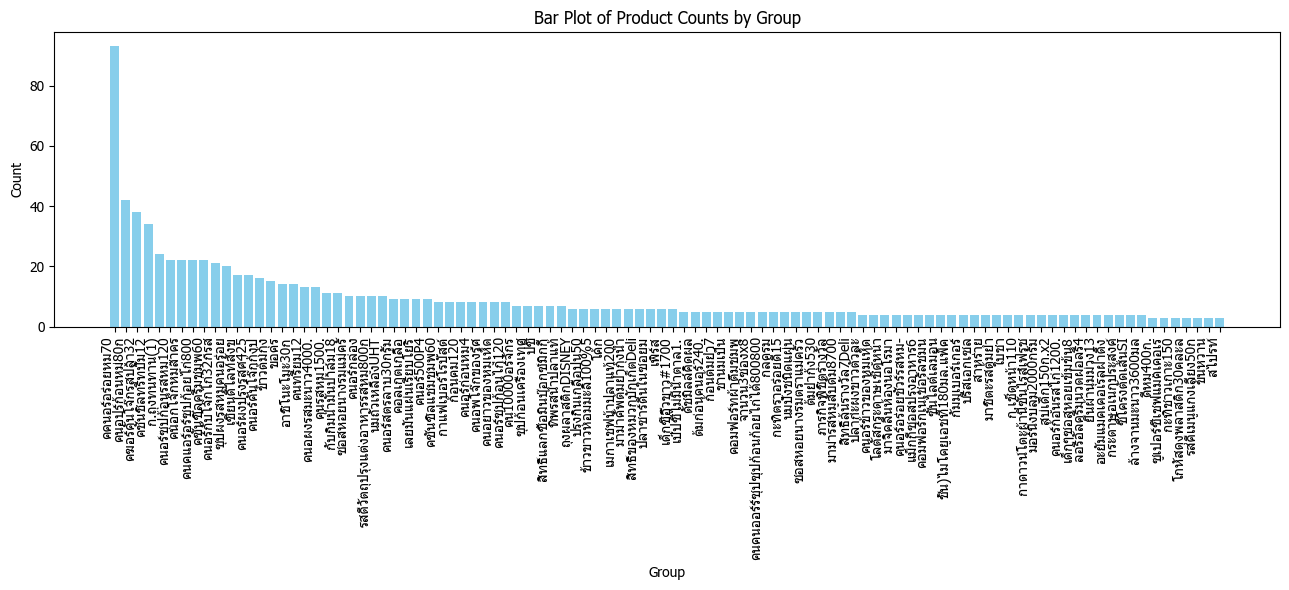

In [12]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt

# Count occurrences of each group
group_counts = df['Group'].value_counts()[:100]

# Plot the bar chart
plt.figure(figsize=(13, 6))
plt.bar(group_counts.index, group_counts.values, color='skyblue')
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Bar Plot of Product Counts by Group')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
group_counts.head(10)

Group
คคนอร์อร่อยหม70            93
คนอปร์ก้อนหมู่80ก          42
คฆอร์คันโจ๊กรสปลา32        38
คชันชิลทรีทปั๊ม12          34
ก.ถุงทนทาน(1)              24
คนอร์ซุปก้อนรสหมู120       22
คนอกโจ๊กหมูสาคร            22
คนคแอร์อร์ซุปก้อยไก่800    22
คซันซิลครีมชมพู60          22
คนอร์กับโจ๊กไก่32กรส       21
Name: count, dtype: int64

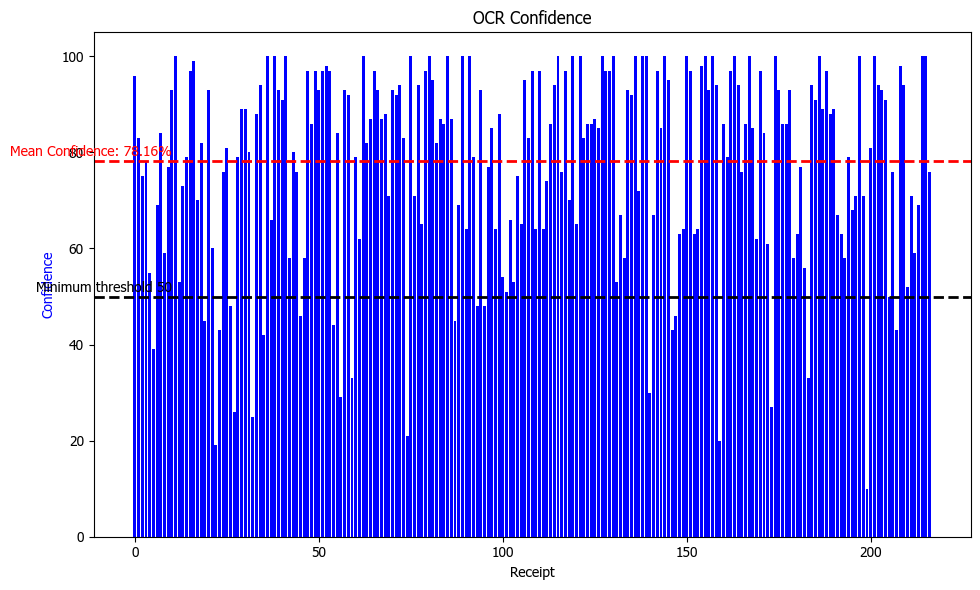

In [14]:
import matplotlib.pyplot as plt

# Create lists for plotting
image_names = list(ocr_goods.keys())
confidence_values = [ocr_goods[image]['confidence'] for image in image_names]

# Create bar plot for confidence values
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(np.arange(len(image_names)), confidence_values, color='blue', label='Confidence')
# Plot dashed horizontal line at the mean value of confidence
mean_confidence = sum(confidence_values) / len(confidence_values)
ax1.axhline(mean_confidence, color='red', linestyle='dashed', linewidth=2, label='Mean Confidence')
# Add text on top of the mean confidence line
ax1.text(10, mean_confidence + 1, f'Mean Confidence: {mean_confidence:.2f}%', color='red', ha='right')

ax1.text(10, 50 + 1, f'Minimum threshold 50', color='black', ha='right')
ax1.axhline(50, color='black', linestyle='dashed', linewidth=2, label='Minimum threshold')

# Add labels and legend
ax1.set_xlabel('Receipt')
ax1.set_ylabel('Confidence', color='blue')
plt.title('OCR Confidence')
fig.tight_layout()

# Show the plot
plt.show()